In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

## Extract features: spatial features, colot hist and hog

In [2]:
def bin_spatial(_img, size=(32, 32)):
    spatial_features = cv2.resize(_img, size)
    return spatial_features.ravel()


def color_hist(_img, hist_bins=32, color_range=(0, 256)):
    ch1 = np.histogram(_img[:, :, 0], hist_bins, range=color_range)
    ch2 = np.histogram(_img[:, :, 1], hist_bins, range=color_range)
    ch3 = np.histogram(_img[:, :, 2], hist_bins, range=color_range)
    hist_features = np.hstack((ch1[0], ch2[0], ch3[0]))
    return hist_features


def get_hog_features(_img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis:
        features, hog_img = hog(_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                visualize=vis, feature_vector=feature_vec)
        return features, hog_img
    else:
        features = hog(_img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualize=vis, feature_vector=feature_vec)
        return features


def single_img_features(_img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8,
                        cell_per_block=2, hog_channel=0, spatial_flag=True, hist_flag=True, hog_flag=True):
    # 1) define an empty list to receive features
    img_features = []
    # 2) apply color conversion if not 'RGB' color space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(_img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(_img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(_img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(_img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(_img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_img = np.copy(_img)
    # 3) compute spatial features if flag is set
    if spatial_flag:
        spatial_features = bin_spatial(_img, spatial_size)
        img_features.append(spatial_features)
    # 4) compute histogram features is flag is set
    if hist_flag:
        hist_features = color_hist(_img, hist_bins=hist_bins)
        img_features.append(hist_features)
    # 5) compute HOG features if flag is set
    if hog_flag:
        if hog_channel == -1:
            hog_features = []
            for channel in range(feature_img.shape[2]):
                hog_features.append(get_hog_features(feature_img[:, :, channel], orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_img[:, :, hog_channel], orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        img_features.append(hog_features)
    # 6) return concatenated array of all features
    return np.concatenate(img_features)

## Load data file 

There are 8792 cars and 8968 noncars


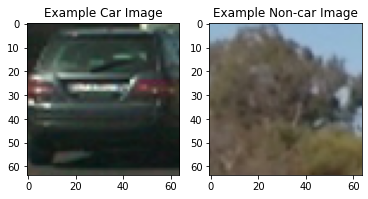

In [3]:
# load image files
car_path = "./training_data/vehicles/vehicles"
notcar_path = "./training_data/non-vehicles"
car_files = []  # stores paths of all car images
notcar_files = []  # stores paths of all not-car images
for car_dir in os.listdir(car_path):
    for car_file in glob.glob(os.path.join(car_path, car_dir) + '/*.png'):
        car_files.append(car_file)
for notcar_dir in os.listdir(notcar_path):
    for notcar_file in glob.glob(os.path.join(notcar_path, notcar_dir) + '/*.png'):
        notcar_files.append(notcar_file)

print("There are {} cars and {} noncars".format(len(car_files), len(notcar_files)))
car_img = cv2.imread(car_files[np.random.randint(len(car_files))])
notcar_img = cv2.imread(notcar_files[np.random.randint(len(notcar_files))])
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_img[:,:,::-1])
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_img[:,:,::-1])
plt.title('Example Non-car Image')
plt.show()

## Extract features and normalize and train model

In [4]:
# extract image features for all images
car_features = []
notcar_features = []
for car_file in car_files:
    car_img = cv2.imread(car_file)
    car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
    img_feature = single_img_features(car_img, color_space='YCrCb', spatial_size=(16, 16), hist_bins=32, orient=9,
                                      pix_per_cell=8, cell_per_block=2, hog_channel=-1, spatial_flag=True,
                                      hist_flag=True, hog_flag=True)
    car_features.append(img_feature)
for notcar_file in notcar_files:
    notcar_img = cv2.imread(notcar_file)
    notcar_img = cv2.cvtColor(notcar_img, cv2.COLOR_BGR2RGB)
    img_feature = single_img_features(notcar_img, color_space='YCrCb', spatial_size=(16, 16), hist_bins=32, orient=9,
                                      pix_per_cell=8, cell_per_block=2, hog_channel=-1, spatial_flag=True,
                                      hist_flag=True, hog_flag=True)
    notcar_features.append(img_feature)

In [5]:
# normalize feature with sklearn.preprocessing
x = np.vstack((car_features, notcar_features)).astype(np.float64)
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print(x.shape, y.shape)

(17760, 6156) (17760,)


In [6]:
# train model
x, y = shuffle(x, y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
svc = LinearSVC(C=0.001, verbose=True, random_state=0)
svc.fit(x_train, y_train)
test_acc = svc.score(x_test, y_test)
print("The test accuracy is %.4f" % test_acc)

[LibLinear]The test accuracy is 0.9918


## draw boxes and define list of windows

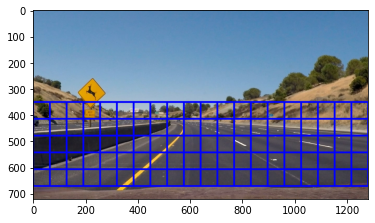

In [7]:
def draw_boxes(_img, bboxes, color=(0, 0, 255), thick=6):
    img = np.copy(_img)
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    return img

def list_windows(_img, x_range=[None, None], y_range=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # if x and/or y start/stop positions not defined, set to image size
    if x_range[0] is None:  x_range[0] = 0
    if x_range[1] is None:  x_range[1] = _img.shape[1]
    if y_range[0] is None:  y_range[0] = 0
    if y_range[1] is None:  y_range[1] = _img.shape[0]
    # compute the span of the region to be searched
    xspan = x_range[1] - x_range[0]
    yspan = y_range[1] - y_range[0]
    # compute the number of pixels per step in x or y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # compute the number of windows in x or y
    x_buffer = np.int(xy_window[0] * xy_overlap[0])
    y_buffer = np.int(xy_window[1] * xy_overlap[1])
    nx_windows = np.int((xspan - x_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - y_buffer) / ny_pix_per_step)
    # loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            xstart = xs * nx_pix_per_step + x_range[0]
            xend = xstart + xy_window[0]
            ystart = ys * ny_pix_per_step + y_range[0]
            yend = ystart + xy_window[1]
            window_list.append(((xstart, ystart), (xend, yend)))
    return window_list


test_img = cv2.imread('./test_images/test2.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
windows = list_windows(test_img, x_range=[None, None], y_range=[350, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(test_img, windows)
plt.imshow(window_img)

## search in the window and apply heatmap with threshold

In [8]:
def search_windows(_img, windows, clf, scaler, color_space='RGB', spatial_size=(16, 16), hist_bins=32,
                    hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                    spatial_flag=True, hist_flag=True, hog_flag=True):
    on_windows = []
    for window in windows:
        crop_img = _img[window[0][1]:window[1][1], window[0][0]:window[1][0], :]
        crop_img = cv2.resize(crop_img, (64, 64))
        feature = single_img_features(crop_img, color_space=color_space, spatial_size=spatial_size,
                                      hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                      cell_per_block=cell_per_block, hog_channel=hog_channel,
                                      spatial_flag=spatial_flag, hist_flag=hist_flag, hog_flag=hog_flag)
        feature = scaler.transform(feature.reshape(1, -1))
        prediction = clf.predict(feature)
        if prediction == 1:  on_windows.append(window)
    return on_windows

def add_heat(_img, hot_windows):
    mask = np.zeros_like(_img[:, :, 0])
    for window in hot_windows:
        mask[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return mask

def apply_threshold(heat, threshold):
    heat[heat<threshold] = 0
    return heat

def draw_labeled_bboxes(_img, labels):
    img = np.copy(_img)
    # iterate through all detected cars
    for car_num in range(1, labels[1] + 1):
        # find pixels with each car number label value
        nonzero = (labels[0] == car_num).nonzero()
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # bounding box based on min and max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # draw box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    return img

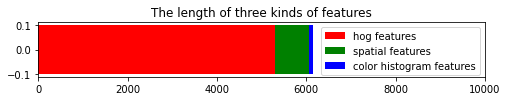

In [9]:
test=cv2.imread(car_files[0])
features=single_img_features(test, color_space='YCrCb', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=-1,
                        spatial_flag=True, hist_flag=True, hog_flag=True)

plt.figure(figsize=(8,1))
plt.barh(0.0, 5292, 0.2, color='r',left=0)
plt.barh(0.0, 768,0.2, color='g',left=5292)
plt.barh(0.0, 96, 0.2, color='b', left=5292+768)
plt.xlim(0,10000)
plt.legend(['hog features', 'spatial features', 'color histogram features'], loc='upper right')
plt.title('The length of three kinds of features')
plt.show()

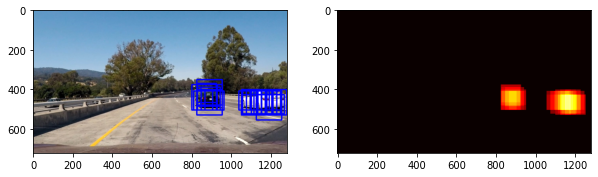

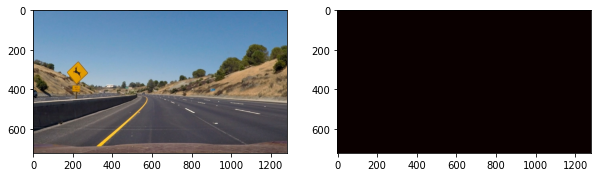

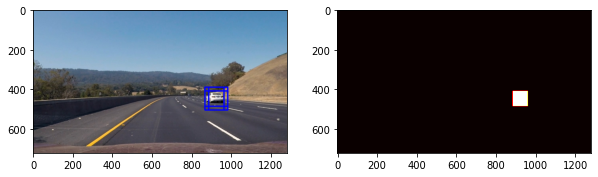

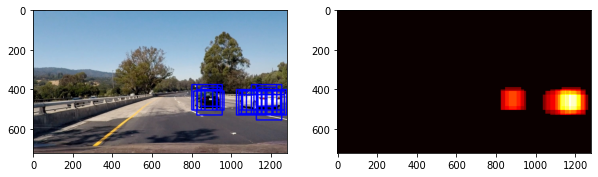

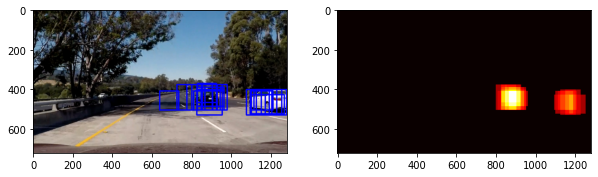

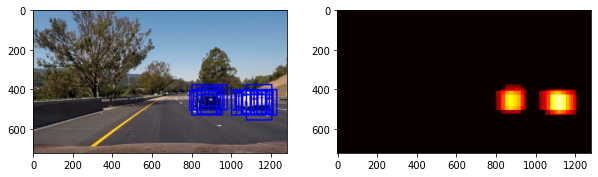

In [10]:
test_imgs = glob.glob('test_images/*.jpg')
orient = 9
spatial_size = (16, 16)
hist_bins = 32
pix_per_cell = 8
cell_per_block = 2
hog_channel = -1
xy_windows = [(96, 96), (128, 128)]
image_windows = []

for test_img in test_imgs:
    image = cv2.imread(test_img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    total_windows = []
    for xy_window in xy_windows:
        windows = list_windows(image, x_range=[600, None], y_range=[350, 660],
                               xy_window=xy_window, xy_overlap=(0.8, 0.8))
        total_windows.extend(windows)
    hot_windows = search_windows(image, total_windows, svc, scaler, color_space='YCrCb',
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 hist_range=(0, 256), orient=orient,
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_flag=True,
                                 hist_flag=True, hog_flag=True)
    image_windows.append(hot_windows)
    draw_img = draw_boxes(image, hot_windows)
    heatmap = add_heat(image, hot_windows)
    heatmap = apply_threshold(heatmap, 3)
    
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(draw_img)
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='hot')
    plt.show()

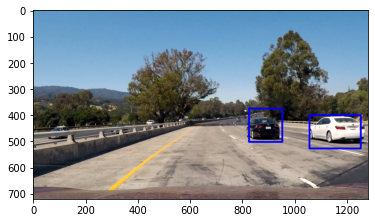

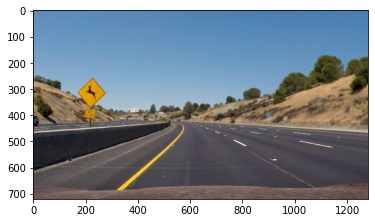

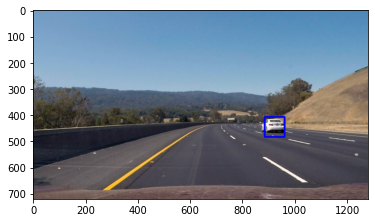

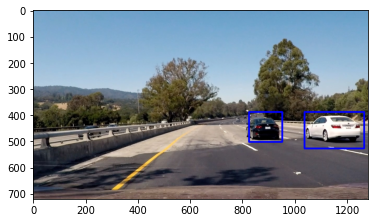

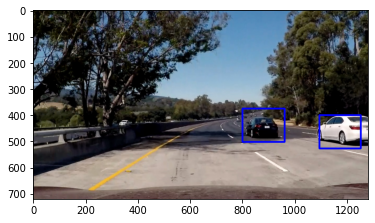

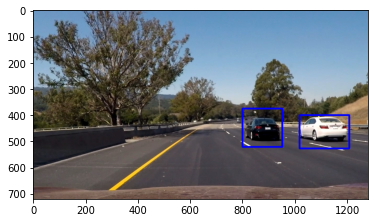

In [11]:
for i, test_img in enumerate(test_imgs):
    img = cv2.imread(test_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    window_img = draw_boxes(img, image_windows[i], color=(0, 0, 255), thick=6)                    
    heatmap = add_heat(img, image_windows[i])
    heatmap = apply_threshold(heatmap, 3)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    
    # display the image
    plt.imshow(draw_img)
    plt.show()

In [12]:
def preprocess(_img):
    xy_windows = [(96, 96), (128, 128)]
    total_windows = []
    for xy_window in xy_windows:
        windows = list_windows(_img, x_range=[600, None], y_range=[350, 660],
                               xy_window=xy_window, xy_overlap=(0.8, 0.8))
        total_windows.extend(windows)
    hot_windows = search_windows(_img, total_windows, svc, scaler, color_space='YCrCb',
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 hist_range=(0, 256), orient=orient,
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_flag=True,
                                 hist_flag=True, hog_flag=True)
    image_windows.append(hot_windows)
    draw_img = draw_boxes(_img, hot_windows)
    heatmap = add_heat(_img, hot_windows)
    heatmap = apply_threshold(heatmap, 3)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(_img, labels)
    return draw_img

In [13]:
output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(preprocess) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

t:   0%|                                                                              | 0/38 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_video_output.mp4.
Moviepy - Writing video test_video_output.mp4



Moviepy - Done !
Moviepy - video ready test_video_output.mp4
Wall time: 1min 53s


In [14]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(preprocess) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 1h 8min 58s
